In [124]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.api as sm
import pylab as py
from scipy.stats import kstest
import os

In [61]:
data = pd.read_csv('kaggle_survey_2020_responses.csv')
data = data[['Time from Start to Finish (seconds)', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']]

C:\Users\Owner\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [62]:
questions = data.iloc[0]
questions

Time from Start to Finish (seconds)                                Duration (in seconds)
Q1                                                           What is your age (# years)?
Q2                                                What is your gender? - Selected Choice
Q3                                             In which country do you currently reside?
Q4                                     What is the highest level of formal education ...
Q5                                     Select the title most similar to your current ...
Q6                                     For how many years have you been writing code ...
Name: 0, dtype: object

In [63]:
responses = data.iloc[1:]
responses

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6
1,1838,35-39,Man,Colombia,Doctoral degree,Student,5-10 years
2,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years
3,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years
4,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years
5,78,30-34,Man,Japan,Master’s degree,Software Engineer,3-5 years
...,...,...,...,...,...,...,...
20032,126,18-21,Man,Turkey,Some college/university study without earning ...,NaN,NaN
20033,566,55-59,Woman,United Kingdom of Great Britain and Northern I...,Master’s degree,Currently not employed,20+ years
20034,238,30-34,Man,Brazil,Master’s degree,Research Scientist,< 1 years
20035,625,22-24,Man,India,Bachelor’s degree,Software Engineer,3-5 years


In [64]:
temp = responses['Time from Start to Finish (seconds)'].astype(int)
responses = responses.assign(**{'Time from Start to Finish (seconds)': temp})

#### Permutation Test for Difference in Survey Completion Time Among Males and Females

In [65]:
responses.groupby('Q2')['Time from Start to Finish (seconds)'].mean()

Q2
Man                         9147.107543
Nonbinary                   6231.076923
Prefer not to say          10236.680608
Prefer to self-describe     3647.444444
Woman                       9234.141826
Name: Time from Start to Finish (seconds), dtype: float64

In [66]:
responses.groupby('Q2')['Time from Start to Finish (seconds)'].median()

Q2
Man                        635.0
Nonbinary                  531.0
Prefer not to say          558.0
Prefer to self-describe    629.5
Woman                      594.0
Name: Time from Start to Finish (seconds), dtype: float64

In [67]:
responses['Q2'].value_counts()

Man                        15789
Woman                       3878
Prefer not to say            263
Prefer to self-describe       54
Nonbinary                     52
Name: Q2, dtype: int64

In [68]:
# Observed absolute difference in mean of survey completion time between men and women

male = responses[responses['Q2'] == "Man"]
female = responses[responses['Q2'] == "Woman"]
obs_mean = np.abs(np.mean(male['Time from Start to Finish (seconds)']) - 
                    np.mean(female['Time from Start to Finish (seconds)']))
obs_mean

87.03428245704526

In [69]:
obs_median = np.abs(np.median(male['Time from Start to Finish (seconds)']) - 
                    np.median(female['Time from Start to Finish (seconds)']))
obs_median

41.0

In [70]:
temp = copy.deepcopy(responses)

In [71]:
# Permutation Test with absolute differnece in means

stats = []
n_reps = 1000

# permutation test
for x in range(n_reps):
    # sampling from and shuffling the funding groups to reassign the groups
    shuffle = temp['Q2'].sample(replace = False, frac = 1).reset_index(drop = True)
    shuffled = temp.assign(**{'Q2': shuffle})
        
    # recalculation of the test stat for the new sample
    new_male = shuffled[shuffled['Q2'] != "Man"]
    new_female = shuffled[shuffled['Q2'] == "Woman"]
    stat = np.abs(np.mean(new_male['Time from Start to Finish (seconds)']) - 
                    np.mean(new_female['Time from Start to Finish (seconds)']))
    
    stats.append(stat)

# computing p_value by comparing the test stats to the inital observed value
p_val = np.count_nonzero(np.array(stats) >= obs_mean) / n_reps


p_val

0.773

Text(0.5, 1.0, 'Permutation Test of Mean Survey Completion Time for Males and Females')

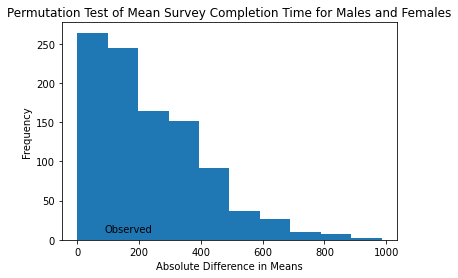

In [78]:
# Histogram distribution of all the shuffled test stats

pd.Series(stats).plot(kind = 'hist')
plt.scatter(obs_mean, 10, color = 'red', s = 50)
plt.annotate("Observed", (obs_mean, 10))

plt.xlabel('Absolute Difference in Means')
plt.ylabel('Frequency')
plt.title('Permutation Test of Mean Survey Completion Time for Males and Females')

In [79]:
temp = copy.deepcopy(responses)

In [81]:
# permutation test with absolute difference in median

stats = []
n_reps = 1000

# permutation test
for x in range(n_reps):
    # sampling from and shuffling the funding groups to reassign the groups
    shuffle = temp['Q2'].sample(replace = False, frac = 1).reset_index(drop = True)
    shuffled = temp.assign(**{'Q2': shuffle})
        
    # recalculation of the test stat for the new sample
    new_male = shuffled[shuffled['Q2'] != "Man"]
    new_female = shuffled[shuffled['Q2'] == "Woman"]
    stat = np.abs(np.median(new_male['Time from Start to Finish (seconds)']) - 
                    np.median(new_female['Time from Start to Finish (seconds)']))
    
    stats.append(stat)

# computing p_value by comparing the test stats to the inital observed value
p_val = np.count_nonzero(np.array(stats) >= obs_median) / n_reps


p_val

0.0

Text(0.5, 1.0, 'Permutation Test of Median Survey Completion Time for Males and Females')

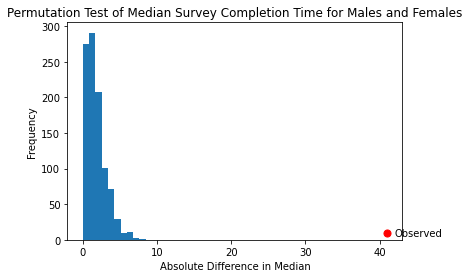

In [85]:
# Histogram distribution of all the shuffled test stats

pd.Series(stats).plot(kind = 'hist')
plt.scatter(obs_median, 10, color = 'red', s = 50)
plt.annotate("Observed", (obs_median + 1, 5))

plt.xlabel('Absolute Difference in Median')
plt.ylabel('Frequency')
plt.title('Permutation Test of Median Survey Completion Time for Males and Females')

#### Point and Interval Estimates and Analysis of Completion Time using Bootstraps

Text(0.5, 1.0, 'Historgram of Observed Survey Completion Times')

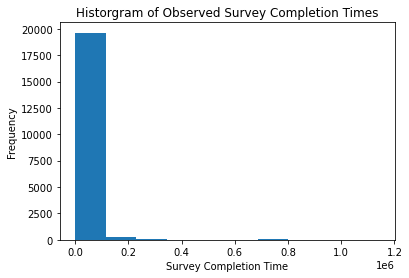

In [88]:
# Survey Completion Time distribution has no structure, warrants a bootstrap

responses['Time from Start to Finish (seconds)'].plot(kind = 'hist')
plt.xlabel('Survey Completion Time')
plt.title('Historgram of Observed Survey Completion Times')

In [98]:
# Bootstrap time completion data and obtain a sample of means

np.random.seed(2021)
durations = responses['Time from Start to Finish (seconds)']
sample = np.random.choice(durations, size = len(durations), replace = True)

boot_means = []
for x in range(5000):
    temp = np.random.choice(sample, size = len(durations), replace = True)
    boot_means.append(np.mean(temp))    

Text(0.5, 1.0, 'Histogram of Bootstrapped Means of Survey Completion Time Vs. Normal Dist')

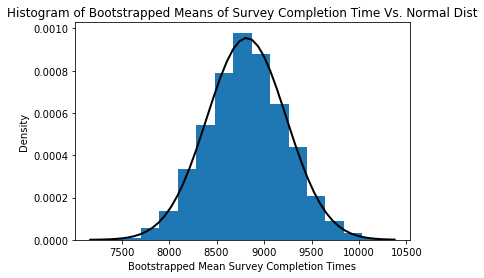

In [114]:
# Plot of the normal distribution over the histogram of boot means

plt.hist(boot_means, bins = 15, density = True)
mu, std = norm.fit(boot_means)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel("Bootstrapped Mean Survey Completion Times")
plt.ylabel("Density")
plt.title("Histogram of Bootstrapped Means of Survey Completion Time Vs. Normal Dist")

In [128]:
# Confirm that the bootstrapped means are approximately normally distributed
normalized_bm = (boot_means - np.mean(boot_means)) / (np.std(boot_means))
kstest(normalized_bm, 'norm')

KstestResult(statistic=0.011308307268098505, pvalue=0.5409524565596786)

In [131]:
obs_mean = np.mean(responses['Time from Start to Finish (seconds)'])
interval = (obs_mean - (1.96 * np.std(boot_means)), obs_mean + (1.96 * np.std(boot_means)))
print("Point Estimate (Mean) of Completion Time: " + str(np.mean(boot_means)))
print("SE of Completion Time: " + str(np.std(boot_means)))
print("Interval Estimate for Completion Time: " + str(interval))

Point Estimate (Mean) of Completion Time: 8816.229669864244
SE of Completion Time: 417.684134153192
Interval Estimate for Completion Time: (8337.203940341835, 9974.525746222349)
